In [1]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee

In [2]:
# Cargamos nuestra tabla de datos con tres columnas x, y, y_error
arr = np.load('test_line.npy')

In [3]:
x= arr[0]
y= arr[1]
y_err=arr[2]
sd=np.std(arr[2])

In [4]:
# Fit a line, y = px + b, through some noisy data-points
A = np.vstack([arr[0], np.ones(len(arr[0]))]).T
p, b = np.linalg.lstsq(A, arr[1], rcond=None)[0]
# El valor de la pendiente de este ajuste es p y b su ordenada al origen
p, b, sd

(30.762307652444512, 199.34272404405507, 11.655808659233418)

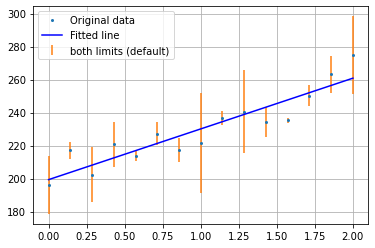

In [6]:
# Hacemos el ajuste lineal 

plt.plot(x, y, 'o', label='Original data', markersize=2)
plt.plot(arr[0], p*arr[0] + b, 'b', label='Fitted line')
plt.errorbar(arr[0], arr[1],yerr= arr[2],ls='',label='both limits (default)')
plt.legend()
plt.grid()
plt.show()

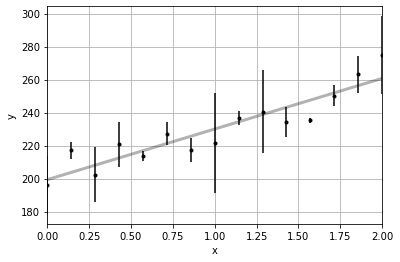

In [7]:
# Choose the "true" parameters.
m_true = 30.7
b_true = 199.34
f_true = 0.018



plt.errorbar(arr[0], arr[1], arr[2], fmt=".k", capsize=0)
x0 = np.linspace(0, 2, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 2)
plt.xlabel("x")
plt.grid()
plt.ylabel("y");



Least-squares estimates:
m = 19.339 ± 2.411
b = 206.785 ± 3.165


NameError: name 'm_ml' is not defined

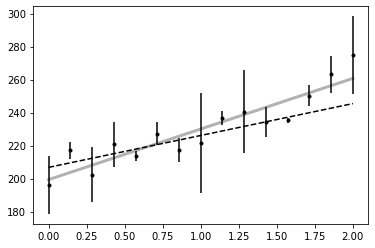

In [8]:

A = np.vander(arr[0], 2)
C = np.diag(arr[2] * arr[2])
ATA = np.dot(A.T, A / (arr[2] ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, arr[1] / arr[2] ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

x0 = np.linspace(0, 2, 500)
plt.errorbar(arr[0], arr[1], arr[2], fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("x")
plt.ylabel("y");

In [9]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = 22.483
b = 205.969
f = 0.018


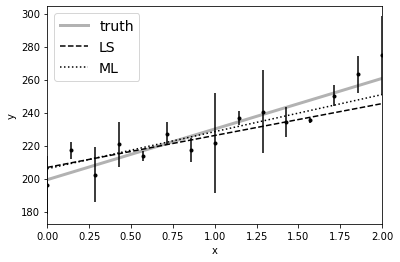

In [10]:

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(arr[0], arr[1], arr[2]))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(arr[0], arr[1], arr[2], fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("x")
plt.ylabel("y");

In [11]:
def log_prior(theta):
    m, b, log_f = theta
    if -100.0 < m < 100.0 and 0.0 < b < 400.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [12]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(arr[0], arr[1], arr[2]))
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 588.08it/s]


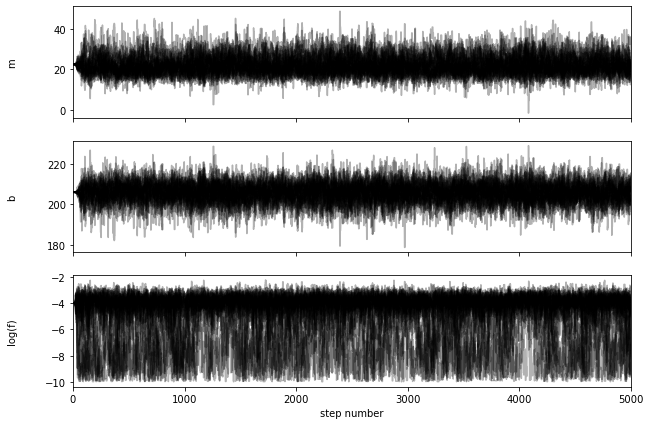

In [13]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [14]:

tau = sampler.get_autocorr_time()
print(tau)

[47.35079968 39.98005671 89.25826333]


In [15]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


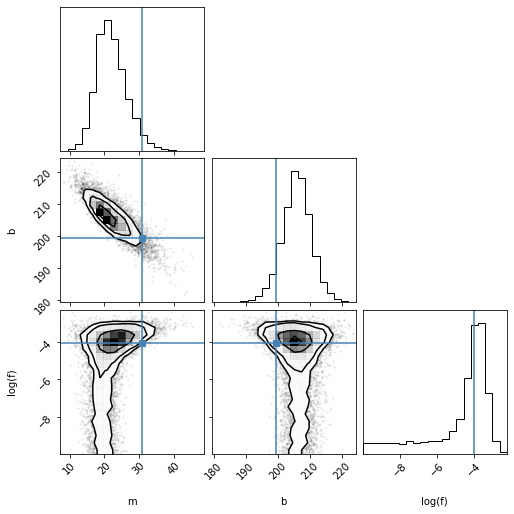

In [16]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

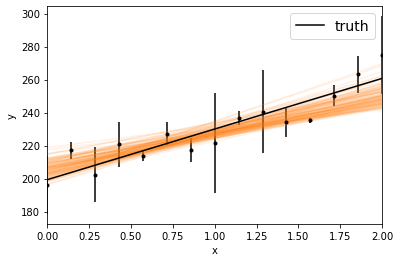

In [17]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(arr[0], arr[1], arr[2], fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("x")
plt.ylabel("y");

In [18]:

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>